Import required libraries

In [1]:
import nltk
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report



download necessary Natural language toolkit libriries for lemmen and tokenization

In [2]:
nltk.download(['punkt','punkt_tab','stopwords'], quiet=True)

True

separate data into train test sets

In [3]:
train_df = pd.read_csv('https://raw.githubusercontent.com/Jana-Liebenberg/2401PTDS_Classification_Project/main/Data/processed/train.csv', sep=',', encoding='utf-8')
test_df = pd.read_csv('https://raw.githubusercontent.com/Jana-Liebenberg/2401PTDS_Classification_Project/main/Data/processed/test.csv', sep=',', encoding='utf-8')

View dimensions of graph

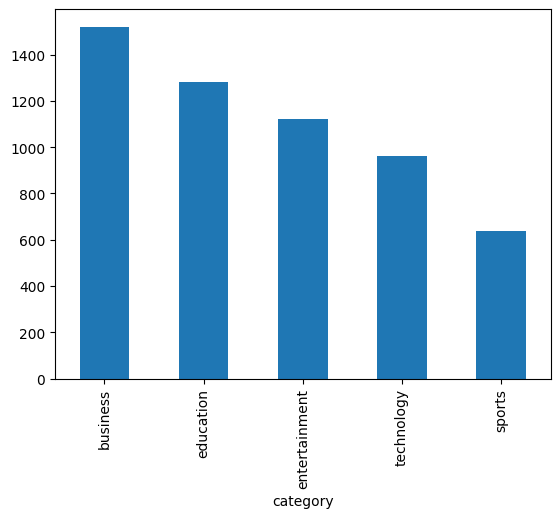

In [4]:
train_plot = train_df['category'].value_counts().plot(kind='bar')
test_plot = test_df['category'].value_counts().plot(kind='bar')


plt.show()

### 1) Format data
in the following order:
1) test on headline data given it is easier to split


In [5]:

def remove_punctuation_numbers_and_stopwords(text):
    text = text.lower()

    pun_nums = string.punctuation + "0123456789"
    stop_words = set(stopwords.words('english'))

    word_tokens = word_tokenize(text)   #Tokenize text to find stopwords more easily 

    filterd_text = " ".join([w for w in word_tokens if w not in (stop_words and pun_nums) and char.is])

    second_check = re.sub(r'[^\w\s]','',filterd_text)

    return second_check

SyntaxError: invalid syntax (977905545.py, line 9)

In [111]:
"""
Here we remove any punctuations and numbers that might have been in the data using the method declared
before for:
"""

#Headlines Data:
train_df['headlines'] = train_df['headlines'].apply(remove_punctuation_numbers_and_stopwords)
test_df['headlines'] = test_df['headlines'].apply(remove_punctuation_numbers_and_stopwords)

#Description Data:
train_df['description'] = train_df['description'].apply(remove_punctuation_numbers_and_stopwords)
test_df['description'] = test_df['description'].apply(remove_punctuation_numbers_and_stopwords)

#Content Data:
train_df['content'] = train_df['content'].apply(remove_punctuation_numbers_and_stopwords)
test_df['content'] = test_df['content'].apply(remove_punctuation_numbers_and_stopwords)

### 2) Feature Engeneering

In [112]:
""""
Here we format our target variables:

"""
y_train = train_df['category']
y_test = test_df['category']

y_train.shape

(5520,)

In [113]:
"""
Here we format our featurs:

Since CountVectorizer has a paramenter for stopwords, we dont need to implement a method
to identify them.

"""
def vectorize_data(column):
    vect = CountVectorizer(stop_words=stopwords.words('english'),min_df=0.05)
    X_train = vect.fit_transform(train_df[column]).toarray()       #we use .toarray() to convert the matrix into a numpy array
    X_test = vect.transform(test_df[column]).toarray()
    vocabulary = vect.get_feature_names_out()

    return X_train, X_test, vocabulary

X_headlines_train, X_headlines_test, headlines_vocabulary = vectorize_data('headlines')
X_description_train, X_description_test, description_vocabulary = vectorize_data('description')
X_content_train, X_content_test, content_vocabulary = vectorize_data('content')


print('X_headlines-train:',X_headlines_train.shape)
print('X_headlines-test:',X_headlines_test.shape)

X_headlines-train: (5520, 99)
X_headlines-test: (2000, 99)


In [114]:
vocabulary_map = {
    'headlines': headlines_vocabulary,
    'description': description_vocabulary,
    'content': content_vocabulary,
}

In [121]:
vocabulary_map

{'headlines': array(['10', '12th', '15', '2023', '2024', 'actor', 'ai', 'air', 'animal',
        'announces', 'apple', 'australia', 'bank', 'begins', 'best',
        'board', 'box', 'check', 'class', 'collection', 'colleges',
        'counselling', 'courses', 'cr', 'crore', 'cuet', 'cup', 'day',
        'declared', 'delhi', 'exam', 'exams', 'film', 'final', 'first',
        'get', 'gets', 'global', 'google', 'govt', 'high', 'iit', 'india',
        'indian', 'jee', 'july', 'kapoor', 'khan', 'know', 'last',
        'launch', 'launches', 'life', 'list', 'main', 'may', 'microsoft',
        'neet', 'new', 'next', 'nifty', 'office', 'online', 'open', 'pg',
        'pro', 'ranbir', 'rbi', 'registration', 'released', 'report',
        'result', 'results', 'reveals', 'review', 'rs', 'rukh', 'samsung',
        'says', 'see', 'sensex', 'set', 'shah', 'shares', 'students',
        'study', 'tech', 'test', 'time', 'today', 'top', 'ug',
        'university', 'us', 'vs', 'watch', 'world', 'year', 'ye

### 3) Model training  

Random Forest Accuracy: 0.6295

Classification Report:
                precision    recall  f1-score   support

     business       0.67      0.56      0.61       400
    education       0.86      0.76      0.81       400
entertainment       0.77      0.69      0.73       400
       sports       0.81      0.36      0.50       400
   technology       0.40      0.78      0.53       400

     accuracy                           0.63      2000
    macro avg       0.70      0.63      0.63      2000
 weighted avg       0.70      0.63      0.63      2000



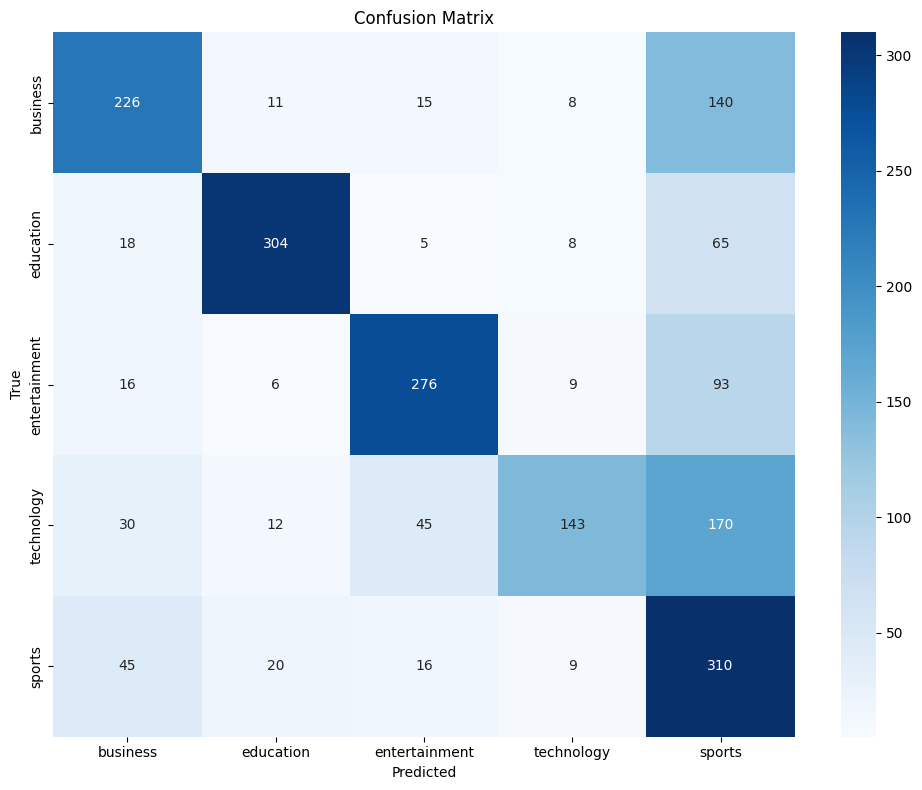

In [115]:

def fit_random_forest(X_train, y_train, X_test, y_test, class_names=None):
   
    rf_model = RandomForestClassifier()
    rf_model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = rf_model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Create a figure for the confusion matrix
    confusion_matrix_fig = plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()

    #Generate classification report
    classification_report_str = classification_report(y_test, y_pred)

    return rf_model, confusion_matrix_fig, accuracy, classification_report_str


class_names = y_test.unique()
clf_model, clf_graph, clf_accuracy, clf_report = fit_random_forest(X_headlines_train, y_train, X_headlines_test, y_test, class_names=class_names)

print('Random Forest Accuracy:', clf_accuracy)
print("\nClassification Report:\n", clf_report)


Multinomial Naive Bayes Multi-Class Accuracy: 0.5945

Classification Report:
                precision    recall  f1-score   support

     business       0.73      0.52      0.61       400
    education       0.41      0.88      0.56       400
entertainment       0.84      0.62      0.71       400
   technology       0.76      0.42      0.54       400
       sports       0.62      0.53      0.57       400

     accuracy                           0.59      2000
    macro avg       0.67      0.59      0.60      2000
 weighted avg       0.67      0.59      0.60      2000



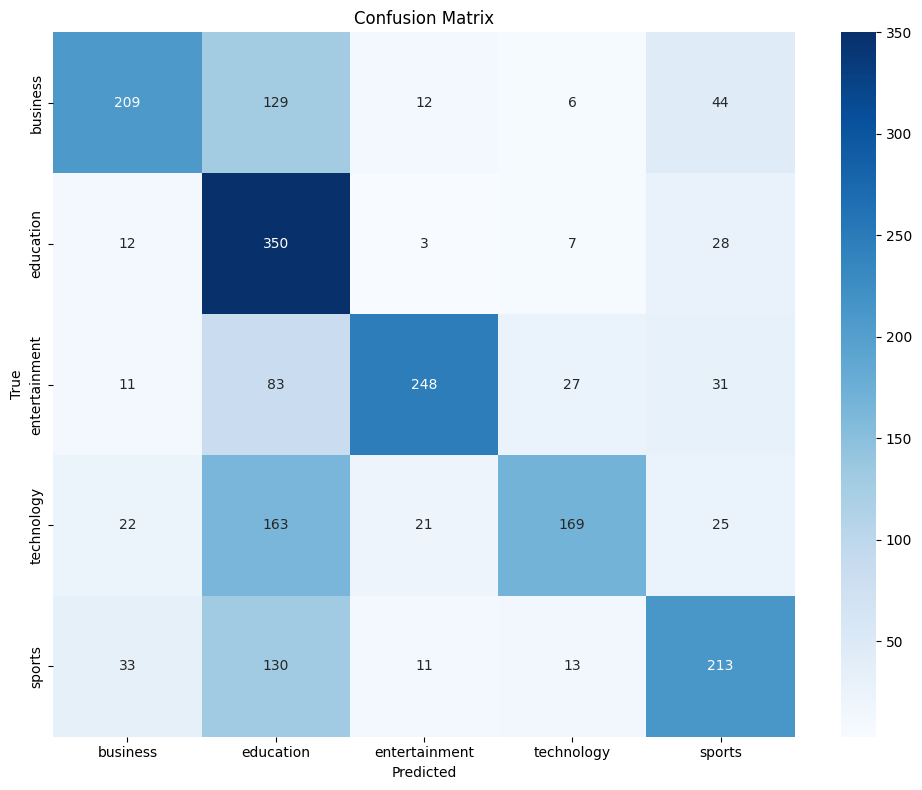

In [116]:
def fit_multinomial_nb_multiclass(X_train, y_train, X_test, y_test, class_names=None):
    
    nb_model = MultinomialNB()  # Initialize the Multinomial Naive Bayes model
    nb_model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = nb_model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Create a figure for the confusion matrix
    confusion_matrix_fig = plt.figure(figsize=(10, 8))  # Increased size for potentially more classes

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()

    # Generate classification report
    classification_report_str = classification_report(y_test, y_pred, target_names=class_names)

    return nb_model, confusion_matrix_fig, accuracy, classification_report_str


class_names = y_test.unique()
nb_model, nb_graph, nb_accuracy, nb_report = fit_multinomial_nb_multiclass(X_headlines_train, y_train, X_headlines_test, y_test, class_names=class_names)

print('Multinomial Naive Bayes Multi-Class Accuracy:', nb_accuracy)
print("\nClassification Report:\n", nb_report)


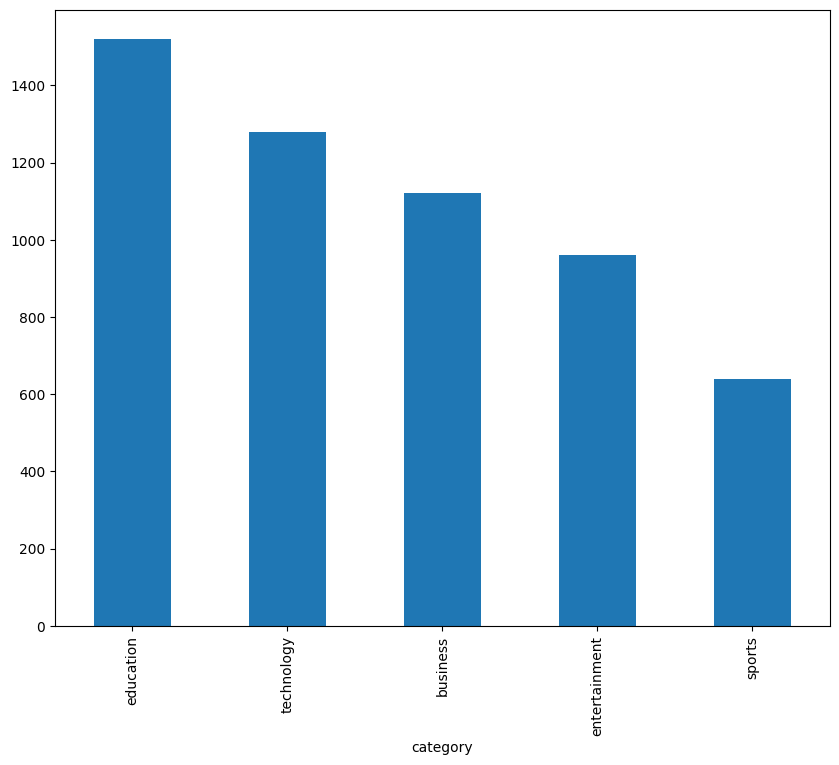

In [117]:
train_df['category'].value_counts().plot(kind='bar',figsize=(10, 8))
plt.show()